### Test of different Data Sets for Evaluating Purposes


In [1]:
import os
import zipfile
import requests
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split

# Step 1: Download Dataset
url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
zip_path = "ml-latest-small.zip"
extract_path = "ml-latest-small"

# Download the ZIP (only if not already done)
if not os.path.exists(zip_path):
    r = requests.get(url)
    with open(zip_path, "wb") as f:
        f.write(r.content)

# Unpack the ZIP (only if not already done)
if not os.path.exists(os.path.join(extract_path, "ml-latest-small")):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)

# Check to save the file in the right nested place
csv_path = os.path.join(extract_path, "ml-latest-small", "ratings.csv")
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"ratings.csv not found in {csv_path}")

ratings = pd.read_csv(csv_path)
print(f"Readed Evaluations: {ratings.shape[0]}")

# ID-Mapping
user_map = {uid: i for i, uid in enumerate(ratings.userId.unique())}
item_map = {iid: j for j, iid in enumerate(ratings.movieId.unique())}
ratings["u"] = ratings.userId.map(user_map)
ratings["i"] = ratings.movieId.map(item_map)





Readed Evaluations: 100836


In [2]:
# Split
df_train, df_test = train_test_split(ratings, test_size=0.2, random_state=42)

# Sparse-Matrices
R_train = csr_matrix((df_train.rating, (df_train.u, df_train.i)),
                     shape=(len(user_map), len(item_map)))
R_test  = csr_matrix((df_test.rating, (df_test.u, df_test.i)),
                     shape=(len(user_map), len(item_map)))


In [3]:
import numpy as np
np.random.seed(42) # seed for reproducibility

# X = 5 * np.random.rand(*R_train.shape)


def generate_initial_X_AW(shape, delta):
    """
    Generates a rank-1 matrix with nuclear norm equal to delta.
    """
    m, n = shape
    u = np.random.randn(m)
    v = np.random.randn(n)
    u /= np.linalg.norm(u)
    v /= np.linalg.norm(v)
    X_AW = -delta * np.outer(u, v)
    return X_AW

X_start = generate_initial_X_AW(R_train.shape, delta=8_000)

In [4]:
%reload_ext autoreload
%autoreload 2

from algorithms import FW, FWAwayStepInFace, FWPairwiseInFace

experiments = [
    {
        "name": "FW + fixed lr",
        "optimizer": FW(X_start, R_train, delta=8_000, lr_strategy="fixed"),
    },
    {
        "name": "FW + line-search",
        "optimizer": FW(X_start, R_train, delta=8_000, lr_strategy="line-search"),
    }, 
    {
        "name": "Away step FW (InFace) + line-search",
        "optimizer": FWAwayStepInFace(X_start, R_train, delta=8_000),
    },
    {
        "name": "Pairwise FW (InFace) + line-search + 5 rank",
        "optimizer": FWPairwiseInFace(X_start, R_train, delta=8_000, rank=5),
    },

]

In [5]:
%reload_ext autoreload
%autoreload 2
from solver import RecommendationSolver
import time
solver = RecommendationSolver(max_iter=500, eps=10 ** (0))

for exp in experiments:
    optimizer = exp["optimizer"]
    print(f"Running experiment: {exp['name']}")

    start_time = time.process_time()
    solver.fit(optimizer)
    end_time = time.process_time()

    exp["train_error_list"] = solver.train_error_list
    exp["cpu_timings"] = solver.cpu_timings
    exp["duality_gap_list"] = solver.duality_gap_list


    exp["cpu_time"] = end_time - start_time
    solver.reset()

for exp in experiments:
    print(f"{exp['name']}: CPU Time = {exp['cpu_time']:.2f}s")


Running experiment: FW + fixed lr


Converged at iteration 378 with duality gap 0.9911:  75%|███████▌  | 377/500 [00:10<00:03, 34.67it/s, duality_gap=0.991, step_size=0.00528, rmse=0.695]


Running experiment: FW + line-search


Converged at iteration 166 with duality gap 0.9768:  33%|███▎      | 165/500 [00:05<00:10, 31.80it/s, duality_gap=0.977, step_size=0.00415, rmse=0.685]


Running experiment: Away step FW (InFace) + line-search


Converged at iteration 144 with duality gap 0.9915:  29%|██▊       | 143/500 [00:12<00:30, 11.85it/s, duality_gap=0.992, step_size=0.00588, step_type=FW, rmse=0.674]


Running experiment: Pairwise FW (InFace) + line-search + 5 rank


Converged at iteration 98 with duality gap 0.9720:  19%|█▉        | 97/500 [00:15<01:06,  6.08it/s, duality_gap=0.972, step_size=0.00372, step_type=PairwiseInFace, rmse=0.994]

FW + fixed lr: CPU Time = 91.67s
FW + line-search: CPU Time = 46.98s
Away step FW (InFace) + line-search: CPU Time = 111.96s
Pairwise FW (InFace) + line-search + 5 rank: CPU Time = 148.66s


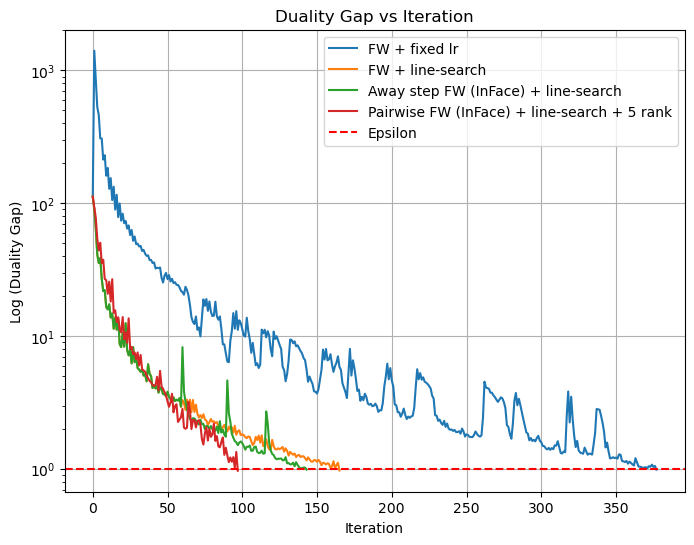

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))  # Optional: slightly more compact
for exp in experiments:
    plt.plot(exp["duality_gap_list"], label=exp["name"])

plt.axhline(y=solver.eps, color='r', linestyle='--', label='Epsilon')

plt.xlabel('Iteration')
plt.ylabel('Log (Duality Gap)')
plt.title('Duality Gap vs Iteration')
plt.grid()
plt.yscale('log')
plt.legend()
plt.show()